<a href="https://colab.research.google.com/github/masadeghi/dementia_clf_fmri/blob/main/experiments/analysis_scripts/fmri_dementia_wt_fe_wandb_sweep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import dependencies

In [ ]:
import os
import gc
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score
from sklearn.utils import class_weight

# from joblib import Parallel, delayed

!pip install -qU tsai
from tsai.all import *
from fastai.callback.tracker import EarlyStoppingCallback, TrackerCallback
from fastai.vision.all import *

!pip install -qU wandb
import wandb
# from wandb.fastai import WandbCallback

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.9/298.9 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 kB 21.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.5 MB/s eta 0:00:00


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set working directory

In [ ]:
# Mount Google drive
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/Coding projects/resting_fmri_dementia/

/content/gdrive/MyDrive/Coding projects/resting_fmri_dementia


# Setup Weights and Biases

## Login to WandB

In [ ]:
wandb.login(key = '####')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Set up parameters dict and sweeep

In [ ]:
sweep_config = {
    'method' : 'random'
}

metric = {
    'name': 'balanced_accuracy',
    'goal': 'maximize'
}

sweep_config['metric'] = metric

parameters_dict = {
    'wvt_max_freq': {'values': ['full', 'half']},                               # The frequency_range for the wavelet transformation.
    'features_ext': {'value': 'custom'},                                           # The method of feature extraction used. {'values': ['custom', 'min']}
    'desired_wvt_freqs': {'value': 'full'},                # Use all or only some of the wavelet-transformed data -- default: "full" // Options: full = all 20; stingy = [3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 17, 19]; lax = [1, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 15, 16, 17, 19]
    'batch_size': {'values': [64, 128]},                                        # batch_size for both time series and tabular data. -- default: [64]
    'seq_len': {'value': 140},                                                  # seq_len for lstm layers.
    'hidden_size': {'values': [256, 512]},                                      # The number of units in the fully connected layer that combines the outputs of the LSTM and the FCN is hidden_size * (1 + bidirectional) + 128 {the number of units of the last conv block}. -- default: 100
    'rnn_layers': {'values': [2, 3]},                                           # Number of LSTM layers. -- default: 1
    'cell_dropout': {'values': [0, 0.1]},                                       # Dropout within the LSTM layer. -- default: 0
    'rnn_dropout': {'values': [0, 0.1]},                                        # Dropout within dropout layer that succeeds the LSTM layer. -- default: 0.8
    'bidirectional': {'values': [True, False]},                                 # Whether the RNN is bidirectional or not. -- default: False
    'ts_fc_dropout': {'value': 0},                                              # Dropout in the fully connected layer that combines the outputs of the LSTM and the FCN. -- default: 0.
    'shuffle': {'value': True},                                                 # If True, LSTM receives data as [B, M, Q] and sequence_length is Q. If False, LSTM receives data as [B, Q, M] and sequence_length is M. -- default: True
    'se': {'values': [0, 8, 16]},                                               # A reduction ratio of 16 was used in the original paper, while 0 removes the sqeeze-excite block from the model -- default: 0
    'tabular_layers': {'value': [200, 100]},                                    # Number of layers in tabular model -- default: [200, 100]
    'tab_fc_dropout': {'values': [0.2, 0.3, 0.4]},                              # Dropout in tabular model -- default: 0
    'use_bn': {'value': True},                                                  # Batch normalization layers alongisde each linear layer in the tabular model. -- default: True
    'bn_final': {'value': False},                                               # Batch normalization layer in the final layer of the tabular model. -- default: False
    'bn_cont': {'value': True},                                                 # Batch normalization on continuous inputs. -- default: True
    'skip': {'values': [True, False]},                                          # Skip function like resnet. -- default: False
    'optimizer': {'value': "adam"},                                             # -- default: Adam // {'values': ["adam", "sgd"]}
    'loss_function': {'value': None},                                           # -- default: None (gets CrossEntropyLoss from dls) // {'values': [None, "focal_loss"]}
    'gamma': {'value': 2},                                                      # -- default: 2
    'wd': {'values': [1e-4, 1e-5, 1e-6]},                                       # weight decay -- default: None
    'wd_bn_bias': {'value': False},                                             # if wd is applied to BatchNorm layers and bias -- default: False
    'train_bn': {'value': False},                                               # train_bn: whether or not to train BatchNorm layers -- default: True
    'moms': {'values': [[0.99, 0.90, 0.99], [0.95, 0.85, 0.95]]},               # Momentums for the learning rate scheduler -- default: (0.85,0.95,0.85)
    'num_epochs': {'value': 30},
    'train_pct_start': {'value': 0.25},                                         # Percentage of data used initially for the fit_one_cycle.
    'lr_division': {'values': [25, 100, 300]}                                   # The learning rate in fit_one_cycle ranges from lr_max/lr_division to lr_max.
}

sweep_config['parameters'] = parameters_dict

pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'maximize', 'name': 'balanced_accuracy'},
 'parameters': {'batch_size': {'values': [64, 128]},
                'bidirectional': {'values': [True, False]},
                'bn_cont': {'value': True},
                'bn_final': {'value': False},
                'cell_dropout': {'values': [0, 0.1]},
                'desired_wvt_freqs': {'value': 'full'},
                'features_ext': {'value': 'custom'},
                'gamma': {'value': 2},
                'hidden_size': {'values': [256, 512]},
                'loss_function': {'value': None},
                'lr_division': {'values': [25, 100, 300]},
                'moms': {'values': [[0.99, 0.9, 0.99], [0.95, 0.85, 0.95]]},
                'num_epochs': {'value': 30},
                'optimizer': {'value': 'adam'},
                'rnn_dropout': {'values': [0, 0.1]},
                'rnn_layers': {'values': [2, 3]},
                'se': {'values': [0, 8, 16]},
                'seq_len': {'

In [ ]:
sweep_id = wandb.sweep(sweep_config, project = "fmri-dementia-wt-fe-multimodal-ten")

ERROR:wandb.sdk.internal.internal_api:500 response executing GraphQL.
ERROR:wandb.sdk.internal.internal_api:{"errors":[{"message":"An internal error occurred. Please contact support.","path":["upsertSweep"]}],"data":{"upsertSweep":null}}
wandb: ERROR Error while calling W&B API: An internal error occurred. Please contact support. (<Response [500]>)
wandb: Network error (HTTPError), entering retry loop.


Create sweep with ID: czfo2xxb
Sweep URL: https://wandb.ai/masadeghi6/fmri-dementia-wt-fe-multimodal-ten/sweeps/czfo2xxb


## Training procedure

In [ ]:
def train(config = None):

  with wandb.init(config = config):

    config = wandb.config

    X_cwt, features_df, y = load_data(config.wvt_max_freq, config.features_ext)

    class_weights = torch.FloatTensor(class_weight.compute_class_weight('balanced', classes = np.unique(y), y = y))

    loss_function = build_loss_function(config.loss_function, config.gamma, class_weights)

    optimizer = build_optimizer(config.optimizer)

    chosen_wvt_freqs = choose_wvt_freqs(config.desired_wvt_freqs)

    ensemble_accuracy, ensemble_balanced_accuracy, ensemble_f1_score, actual_num_epochs, average_epochs = train_loop(
        X_cwt, features_df, y,
        desired_wvt_freqs = chosen_wvt_freqs,
        batch_size = config.batch_size, # For the tabular and time series data loaders
        sequence_length = config.seq_len, # For the MLSTM-FCN model on time series data:
        n_units_in_hidden_layer = config.hidden_size,
        num_rnn_layers = config.rnn_layers,
        rnn_cell_dropout = config.cell_dropout,
        rnn_whole_dropout = config.rnn_dropout,
        if_bidirectional = config.bidirectional,
        ts_fc_dropout = config.ts_fc_dropout,
        if_shuffle = config.shuffle,
        se_reduction_ratio = config.se,
        n_units_in_tab_layers = config.tabular_layers, # The TabModel on features data
        tab_fc_dropout = config.tab_fc_dropout,
        if_use_tab_bn = config.use_bn,
        if_bn_final = config.bn_final,
        if_bn_cont = config.bn_cont,
        if_skip = config.skip,
        optimizer = optimizer, # The Learner
        loss_function = loss_function,
        weight_decay = config.wd,
        if_wd_bn_bias = config.wd_bn_bias,
        if_train_bn = config.train_bn,
        momentums = config.moms,
        num_epochs = config.num_epochs,
        train_pct_start = config.train_pct_start, # fit_one_cycle
        lr_division = config.lr_division
        )

    wandb.log({"accuracy": ensemble_accuracy, "balanced_accuracy": ensemble_balanced_accuracy, "f1_score": ensemble_f1_score, 'actual_num_epochs': actual_num_epochs, 'average_epochs': average_epochs})

# Functions used in the training procedure

## Function for loading desired dataset

In [ ]:
def load_data(wvt_max_freq, features_ext):

  if wvt_max_freq == 'full':
    X_cwt = np.load('wavelet_transformed_data/X_cwt_final_full.npy', mmap_mode = 'c')
  elif wvt_max_freq == 'half':
    X_cwt = np.load('wavelet_transformed_data/X_cwt_final_half.npy', mmap_mode = 'c')

  if features_ext == 'min':
    features_df = pd.read_csv('features_data/features_final_df_min.csv', index_col = False)
    features_df['target'] = features_df['target'].astype('str')
  elif features_ext == 'custom':
    features_df = pd.read_csv('features_data/features_final_df_custom_mod.csv', index_col = False)
    features_df['target'] = features_df['target'].astype('str')

  y = np.load('scaled_datasets_as_np_arrays/y_final_train_val.npy', mmap_mode = 'c')

  return X_cwt, features_df, y

## Function for generating the loss function

In [ ]:
def build_loss_function(loss_function, gamma = None, class_weights = None):
  if loss_function == None:
    loss_functon = None
  elif loss_function == "focal_loss":
    loss_function = FocalLoss(gamma = gamma)
  return loss_function

## Function for creating the optimizer

In [ ]:
def build_optimizer(optimizer):
  if optimizer == "sgd":
    optimizer = fastai.optimizer.SGD
  elif optimizer == "adam":
    optimizer = fastai.optimizer.Adam
  return optimizer

## Custom multiclassification metrics

In [ ]:
def balanced_accuracy(input, target):
  input, target = input.cpu(), target.cpu()
  input, target = flatten_check(input.argmax(axis = -1), target)
  output = balanced_accuracy_score(target, input)
  return output

# Function for choosing the desired wavelet transformations

In [ ]:
def choose_wvt_freqs(type):
  if type == 'full':
    freqs = np.arange(20)
  elif type == 'lax':
    freqs = np.array([1, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 15, 16, 17, 19])
  elif type == 'stingy':
    freqs = np.array([3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 17, 19])

  return freqs

## Function for runnning the training loop

In [ ]:
train_val_idx = np.load('datasets_as_np_arrays/train_val_idx.npy')
train_idx = np.load('datasets_as_np_arrays/train_idx.npy')
val_idx = np.load('datasets_as_np_arrays/val_idx.npy')
test_idx = np.load('datasets_as_np_arrays/test_idx.npy')

In [ ]:
new_train_idx = np.empty(shape = (len(train_idx), ))
for i, idx in enumerate(train_idx):
  new_train_idx[i] = np.where(train_val_idx == idx)[0].item()
new_train_idx = new_train_idx.astype(np.int64)


new_val_idx = np.empty(shape = (len(val_idx), ))
for i, idx in enumerate(val_idx):
  new_val_idx[i] = np.where(train_val_idx == idx)[0].item()
new_val_idx = new_val_idx.astype(np.int64)

In [ ]:
y_val = np.load('scaled_datasets_as_np_arrays/y_final_val.npy', mmap_mode = 'c')

NameError: ignored

In [ ]:
y_val

In [ ]:
def train_loop(dataset, feature_data, target_data,
               desired_wvt_freqs,
               batch_size,
               sequence_length, n_units_in_hidden_layer, num_rnn_layers, rnn_cell_dropout, rnn_whole_dropout, if_bidirectional, ts_fc_dropout, if_shuffle, se_reduction_ratio, #MLSTM-FCN
               n_units_in_tab_layers, tab_fc_dropout, if_use_tab_bn, if_bn_final, if_bn_cont, if_skip, # TabModel
               optimizer, loss_function, weight_decay, if_wd_bn_bias, if_train_bn, momentums, # Learner
               num_epochs,
               train_pct_start, lr_division
               ):

  # Pick out train and val data from time series and features data
  dataset, feature_data = dataset[train_val_idx, :, :, :], feature_data.loc[train_val_idx, :]

  # train/val split
  splits = tuple([L(list(new_train_idx)), L(list(new_val_idx))])

  # tabular features dataloader and model
  cat_names = None
  cont_names = feature_data.columns[:-1]
  y_names = 'target'

  dls_features = get_tabular_dls(feature_data, # Has normalization of continuous features built in
                                  cat_names = cat_names, cont_names = cont_names,
                                  y_names = y_names, splits = splits, bs = batch_size)

  # Initializing arrays for keeping the model predictions on each wavelet transformation
  number_of_frequencies = len(desired_wvt_freqs)
  val_len = len(val_idx)
  y_probas = np.empty((number_of_frequencies, val_len, 4))
  y_pred = np.empty((number_of_frequencies, val_len))

  # Keeping track of the training performance of each wavelet transformation
  actual_num_epochs = []

  # For each wavelet transformation, train the multi-input model
  for i in desired_wvt_freqs:

    # Extract the desired wavelet-transformed dataset
    X_scale = dataset[:, i, :, :]
    X_scale = np.transpose(X_scale, (0, 2, 1))

    # ts data loader
    tfms = [None, [Categorize()]]
    dls_ts = get_ts_dls(X_scale, target_data.astype(str), splits = splits, tfms = tfms, bs = batch_size)

    # Mixed data loader
    dls_mixed = get_mixed_dls(dls_ts, dls_features)

    # Time series model
    ts_model = MLSTM_FCNPlus(dls_ts.vars, dls_ts.c, seq_len = sequence_length,
                              hidden_size = n_units_in_hidden_layer, rnn_layers = num_rnn_layers,
                              cell_dropout = rnn_cell_dropout, rnn_dropout = rnn_whole_dropout,
                              bidirectional = if_bidirectional, fc_dropout = ts_fc_dropout,
                              shuffle = if_shuffle, se = se_reduction_ratio)

    # Tabular model
    tab_model = build_tabular_model(TabModel, dls = dls_features, layers = n_units_in_tab_layers,
                                    arch_config = {'fc_dropout': tab_fc_dropout, 'use_bn': if_use_tab_bn,
                                                    'bn_final': if_bn_final, 'bn_cont': if_bn_cont,
                                                    'skip': if_skip})

    # Multi-input model
    multimodal_model = MultiInputNet(ts_model, tab_model,
                                    #  multi_output = True
                                     )

    # The training process
    learn = Learner(dls_mixed, multimodal_model, metrics = balanced_accuracy,
                    opt_func = optimizer,
                    loss_func = loss_function,
                    wd = weight_decay,
                    wd_bn_bias = if_wd_bn_bias,
                    train_bn = if_train_bn,
                    moms = momentums)
    lrs = learn.lr_find(suggest_funcs = (minimum, valley))
    final_lr = (lrs.minimum + lrs.valley)/2
    learn.fit_one_cycle(num_epochs,
                        lr_max = final_lr,
                        pct_start = train_pct_start,
                        div = lr_division,
                        cbs = EarlyStoppingCallback(monitor = 'balanced_accuracy', min_delta = 0.02, patience = 5))

    actual_num_epochs.append(learn.epoch)

    # # Export model weights
    # export_path = os.path.join("model_weights", f"exp_20_morl_scale_{i}_min_features_lstm_fcn_30_epochs.pth")
    # learn.export(export_path)

    if loss_function == None:
      probas, _, preds = learn.get_preds(dl = dls_mixed.valid, with_decoded = True)
    else:
      probas, _, _ = learn.get_preds(dl = dls_mixed.valid, with_decoded = True)
      preds = torch.argmax(torch.nn.Softmax(dim = 1)(probas), axis = -1)

    y_probas[i], y_pred[i] = probas, preds

    del ts_model, tab_model, multimodal_model, learn, dls_ts, dls_mixed, probas, preds
    gc.collect()

  # Combine outputs of all wavelet transformations into one prediction
  cumulative_prediction = []

  for i in range(y_pred.shape[1]):
    pred_array = y_pred[:, i]
    values, counts = np.unique(pred_array, return_counts = True)
    idx = np.argmax(counts)
    cumulative_prediction.append(values[idx])

  cumulative_prediction = np.array(cumulative_prediction) + 1

  ensemble_accuracy = np.mean(cumulative_prediction == y_val)
  ensemble_balanced_accuracy = balanced_accuracy_score(y_val, cumulative_prediction)
  ensemble_f1 = f1_score(y_val, cumulative_prediction, average = 'weighted')
  average_epochs = np.mean(actual_num_epochs)
  return ensemble_accuracy, ensemble_balanced_accuracy, ensemble_f1, actual_num_epochs, average_epochs

# Run the sweep

In [ ]:
wandb.agent(sweep_id, train, count = 10)

In [ ]:
from google.colab import runtime
runtime.unassign()

#Test code

In [ ]:
X, features_data, y = load_data(despiking = False, wvt_max_freq = 'full', features_ext = 'min')

In [ ]:
# X_orig = np.load('scaled_datasets_as_np_arrays/X_train_val.npy', mmap_mode = 'c')
# y_orig = np.load('scaled_datasets_as_np_arrays/y_train_val.npy', mmap_mode = 'c')

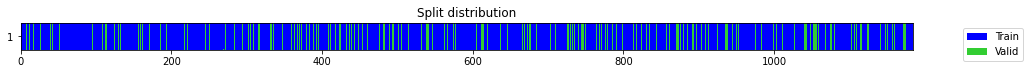

In [ ]:
# train/val split
splits = get_splits(y, valid_size = .2, stratify = True, random_state = 42, shuffle = True)

# tabular features dataloader and model
cat_names = None
cont_names = features_data.columns[:-1]
y_names = 'target'


# Initializing arrays for keeping the model predictions on each wavelet transformation
number_of_frequencies = 20
val_len = int(0.2 * len(y))
y_probas = np.empty((number_of_frequencies, val_len, 4))
y_pred = np.empty((number_of_frequencies, val_len))

In [ ]:
dls_features = get_tabular_dls(features_data, # Has normalization of continuous features built in
                                cat_names = cat_names, cont_names = cont_names,
                                y_names = y_names, splits = splits, bs = sweep_config['parameters']['batch_size']['values'][0])

In [ ]:
class_weights = torch.FloatTensor(class_weight.compute_class_weight('balanced', classes = np.unique(y), y = y))

loss_function = build_loss_function(sweep_config['parameters']['loss_function']['value'], sweep_config['parameters']['gamma']['value'], class_weights)

optimizer = build_optimizer(sweep_config['parameters']['optimizer']['value'])

In [ ]:
# For each wavelet transformation, train the multi-input model
# for i in range(1):

# Extract the desired wavelet-transformed dataset
X_scale = X[:, 0, :, :]
X_scale = np.transpose(X_scale, (0, 2, 1))

# ts data loader
tfms = [None, [Categorize()]]
dls_ts = get_ts_dls(X_scale, y.astype(str), splits = splits, tfms = tfms, bs = sweep_config['parameters']['batch_size']['values'][0])

# Mixed data loader
dls_mixed = get_mixed_dls(dls_ts, dls_features)

# Time series model
ts_model = MLSTM_FCNPlus(dls_ts.vars, dls_ts.c, seq_len = sweep_config['parameters']['seq_len']['value'],
                          hidden_size = sweep_config['parameters']['hidden_size']['values'][0], rnn_layers = sweep_config['parameters']['rnn_layers']['values'][0],
                          cell_dropout = sweep_config['parameters']['cell_dropout']['values'][0], rnn_dropout = sweep_config['parameters']['rnn_dropout']['values'][0],
                          bidirectional = sweep_config['parameters']['bidirectional']['values'][0], fc_dropout = sweep_config['parameters']['ts_fc_dropout']['value'],
                          shuffle = sweep_config['parameters']['shuffle']['value'], se = sweep_config['parameters']['se']['values'][0])

# Tabular model
tab_model = build_tabular_model(TabModel, dls = dls_features, layers = [400, 200, 100],
                                arch_config = {'fc_dropout': sweep_config['parameters']['tab_fc_dropout']['values'][0], 'use_bn': sweep_config['parameters']['use_bn']['value'],
                                                'bn_final': sweep_config['parameters']['bn_final']['value'], 'bn_cont': sweep_config['parameters']['bn_cont']['value'],
                                                'skip': True})

# Multi-input model
multimodal_model = MultiInputNet(ts_model, tab_model,
                                #  multi_output = True
                                  )

# The training process
learn = Learner(dls_mixed, multimodal_model, metrics = balanced_accuracy,
                opt_func = optimizer,
                loss_func = loss_function,
                wd = sweep_config['parameters']['wd']['values'][0],
                wd_bn_bias = sweep_config['parameters']['wd_bn_bias']['value'],
                train_bn = sweep_config['parameters']['train_bn']['value'],
                moms = [0.95, 0.85, 0.95])

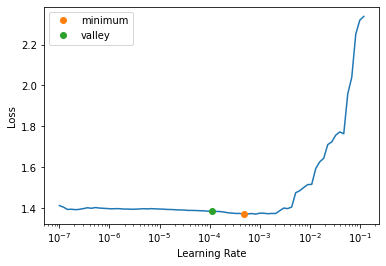

In [ ]:
lrs = learn.lr_find(suggest_funcs = (minimum, valley))

In [ ]:
final_lr = (lrs.minimum + lrs.valley)/2

final_lr

7.875541632529348e-05

In [ ]:
learn.fit_one_cycle(sweep_config['parameters']['num_epochs']['value'],
                    lr_max = final_lr,
                    cbs = [EarlyStoppingCallback(monitor = 'balanced_accuracy', min_delta = 0.1, patience = 5),
                           TrackerCallback(monitor = 'balanced_accuracy')])

epoch,train_loss,valid_loss,balanced_accuracy,time
0,1.392422,1.414370,0.107951,00:01
1,1.382642,1.403345,0.119017,00:01
2,1.370239,1.399338,0.086043,00:01
3,1.355550,1.391526,0.103790,00:01
4,1.338265,1.385071,0.151964,00:01
5,1.318795,1.382124,0.161164,00:01


No improvement since epoch 0: early stopping


In [ ]:
learn.epoch

5

In [ ]:
learn.

In [ ]:
cumulative_prediction = []

for i in range(y_pred_stack.shape[1]):
  pred_array = y_pred_stack[:, i]
  values, counts = np.unique(pred_array, return_counts = True)
  idx = np.argmax(counts)
  cumulative_prediction.append(values[idx])

In [ ]:
cumulative_prediction

In [ ]:
cumulative_prediction = np.array(cumulative_prediction) + 1

ensemble_accuracy = np.mean(cumulative_prediction == y_val)
ensemble_balanced_accuracy = balanced_accuracy_score(y_val, cumulative_prediction)
ensemble_f1 = f1_score(y_val, cumulative_prediction, average = 'weighted')

print(ensemble_accuracy, ensemble_balanced_accuracy, ensemble_f1)

0.4050632911392405 0.3468751577565753 0.3738655198869332
